# Power spectrum of curvature perturbations

Simulating the density field given the power spectrum of curvature perturbations. Even for the delta-unction power spectrum, the density perturbations in the spatial domain is not strict harmonic wave, but rather the modulated harmonic wave.

In [56]:
#loadng the libraries
import numpy as np
import math
import george
from george import kernels
import matplotlib.pyplot as plt

In [57]:
def generate_data(N, rng=(-10, 10)):
    gp = george.GP(0.1 * kernels.CosineKernel(0.05)*kernels.InverseLinearKernel(1.0, 0.1))
    t = rng[0] + np.diff(rng) * np.sort(np.random.rand(N))
    y = gp.sample(t)
    yerr = 0.05 + 0.05 * np.random.rand(N)
    #y += yerr * np.random.randn(N)
    return t, y, yerr

t, y, yerr = generate_data(1000)

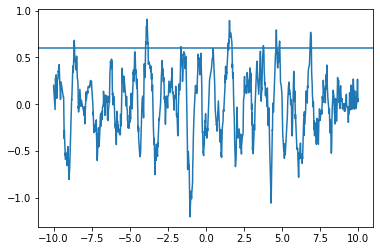

In [58]:
plt.plot(t, y)
plt.axhline(0.6)

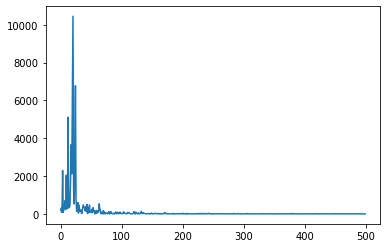

In [59]:
#power spectrum of the density perturbations
plt.plot(abs(np.fft.fft(y)[0:500])**2)

# Smoothing functions

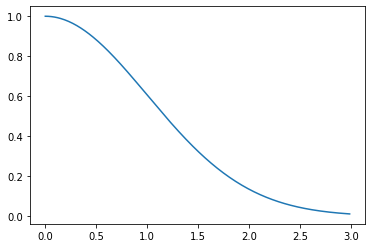

In [60]:
#the broadly used exponential smoothing function
def func(k, R):
    return np.exp(-k**2*R**2/2)
R=1
k=np.asarray([0.01*i for i in range(300)])
plt.plot(k,func(k, R))

# Calculating the fraction PBH/DM

Here we have considered the simplest case within which all PBHs have the same masses. $M_{PBH}$ = $\gamma \times M_H$. The number density function is a delta function. The width of fraction $f_{PBH}$ is infinitely small. 

lgk, Mpc^-1:  6.518339171764072
f, s^-1:  3.5000000000000003e-09
Rh at formation: 15.95878208295559
Uni age, s:  2.3256288253380352e-05
The age is measured unreliable with astropy.
M_pbh, Msun:  0.5336915534000849
We have assumed that H at high z is measured adequately.
f_pbh:  1.335905739779915


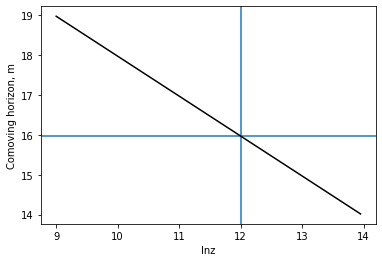

In [116]:
from scipy import interpolate
import astropy.cosmology
import cosmocalc
import scipy.special as sp
from astropy.cosmology import Planck15

#fundamental constants
c=2.*10**8 #m/s
h=Planck15.H0.value/100 # H0=h*100 km/s/Mpc
Mpc=3.*10**22 #Mpc in m
H0_s=1/Planck15.H0.value*3.*10**19 #s H0 in seconds
Msun=2.*10**33 # g
yr2s=3.2*10**7 # s
G=6.67*10**(-14) #g^-1 m^3 s^-2

#parameters of the Universe
Om0=Planck15.Ob0+Planck15.Odm0 #dimensionless density matter (b+CDM) today
Odm0=Planck15.Odm0 #dimensionless density of CDM today
Or0=Planck15.Ogamma0 #dimensionless density of radiation today

#parameters of the PBH formation
delta_c=0.45 #critical density
lgA=-1.4 #amplitude of the power spectrum of curvature perturbations
gamma=0.2 #fraction of the horizon collapsing into black hole
alpha=1.0
f=3.5*10**(-9) #1/m
k_star=2.*np.pi*f/c #frequency 
R_H=alpha/k_star
g_dof=106.75
g_dof_eq=3.
z_eq=Or0/Om0
tau_eq=2.*np.sqrt(2)*(2.*Om0*H0_s**2)**(1/2.)

print("lgk, Mpc^-1: ", np.log10(k_star*Mpc))
print("f, s^-1: ", f)
#calculating the conformal time in radiation dominated epoch
lnz=np.asarray([9.+i*0.05 for i in range(100)]) #the grid of z
R_com_r=1./(Planck15.scale_factor(10**lnz)*Planck15.H(10**lnz).value)*Mpc/10**3*c
print("Rh at formation:",np.log10(R_H))

z2r=interpolate.interp1d(R_com_r, lnz)
z_form=z2r(R_H)
print("Uni age, s: ", cosmocalc.cosmocalc(10**z_form, H0=Planck15.H0.value)['zage_Gyr']*10.**9*yr2s)
print("The age is measured unreliable with astropy.")
#Using cosmocalc to calculate reliable time of formation.
#the size of the comoving horizon at the epoch of formation
plt.axhline(np.log10(R_H))
plt.axvline(z_form)
plt.plot(lnz, np.log10(R_com_r), "black")
plt.xlabel("lnz")
plt.ylabel("Comoving horizon, m")

#mass of the horizon at the epoch of formation
Mpbh=gamma/G/Planck15.H(10**z_form).value*Mpc/10**3*c**3
print("M_pbh, Msun: ", Mpbh/Msun)
print("We have assumed that H at high z is measured adequately.")
#variance for monochromatic spectrum
tau=R_H/c
#print(np.exp(-alpha**2./2.))
sigma2=16/81.*10**lgA*np.exp(-alpha**2./2.)**2*(alpha)**4
beta=np.sqrt(2./np.pi)*np.sqrt(sigma2)/delta_c*np.exp(-delta_c**2/2./sigma2)
beta=sp.erfc(delta_c/np.sqrt(2.)/np.sqrt(sigma2))
#estimate tau_eq from z_eq
tau_eq=1./(Planck15.scale_factor(z_eq)*Planck15.H(z_eq).value)*Mpc/10**3
tau=1./(Planck15.scale_factor(10**z_form)*Planck15.H(10**z_form).value)*Mpc/10**3
f_monoch=beta*10.**z_form/z_eq/Odm0
print("f_pbh: ", f_monoch)

To do: check the realistic mass distribution of PBHs; check other smoothing functions; check how the results depend on delta_c; how PBH abundance depends on alpha (epoch of formation);

Calculate shape of GWB for monochromatic spectrum. Used the results from Kohri, Terada 2018.

In [96]:
def Omega_GW(k, lgA, k_star):
    k_bar=k/k_star
    fac=Or0*(g_dof/g_dof_eq)**(-1/3.)
    omega=fac*(3.*(10**lgA)**2/64.*((4.-k_bar**2)/4.)**2.*k_bar**2*(3.*k_bar**2-2.)**2
                        *(np.pi**2*(3*k_bar**2-2.)**2*np.heaviside(2.*np.sqrt(3.)-3.*k_bar, 2.*np.sqrt(3)-3.*k_bar)
             +(4.+(3.*k_bar**2-2.)*np.log(np.abs(1-4./(3.*k_bar**2))))**2)*np.heaviside(2.-k_bar, 2.-k_bar))
    return omega

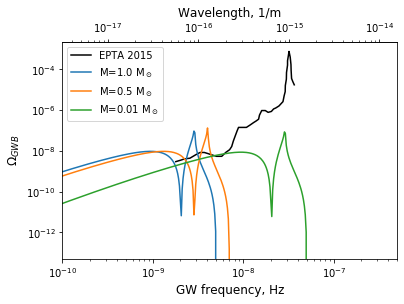

In [121]:
k=np.asarray([-18.+0.01*i for i in range(500)])
def k2f(x):
    return x * c / 2 / np.pi
def f2k(x):
    return 2 * np.pi * x / c
#compare to EPTA limits
epta_list=np.genfromtxt("gwb_dig.dat")
epta_f=epta_list[:,0]
epta_gwb=epta_list[:,1]

plt.xscale("log")
plt.yscale("log")
secax=plt.gca().secondary_xaxis('top', functions=(f2k, k2f))
secax.set_xlabel("Wavelength, 1/m", size=12)
plt.plot(epta_f, epta_gwb, "black", label="EPTA 2015")
plt.xlabel("GW frequency, Hz", size=12)
plt.ylabel("$\Omega_{GWB}$", size=12)
plt.xlim(10**(-10), 5*10**(-7))

f=np.asarray([2.5*10**(-9), 3.5*10**(-9), 2.5*10**(-8)]) #frequency
lgA=[-1.41, -1.41, -1.43]
label=["M=1.0 M$_\odot$", "M=0.5 M$_\odot$", "M=0.01 M$_\odot$"]
k_star=2.*np.pi*f/c
for i in range(3):
    plt.plot(k2f(10**k), Omega_GW(10**k, lgA[i], k_star[i]), label=label[i])
plt.legend(loc=2)
#plt.savefig("GWB_pbh.pdf")